## Домашнее задание 2. Классификация изображений. Сверточные нейронные сети.
### О задании

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

## №1
Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

In [1]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms as T
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from copy import deepcopy

### Подготовка данных

In [ ]:
# Строка для работы в Colab
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

In [2]:
train_transform = T.Compose([
    T.RandomCrop(64, padding=4),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # seminars 2-3 193
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # seminars 2-3 193
])

train_set = tv.datasets.ImageFolder("./dataset/dataset/train", transform=train_transform)
val_set = tv.datasets.ImageFolder("./dataset/dataset/val", transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, pin_memory=True, num_workers=2)

In [3]:
# Простая проверка данных на вшивость (тип элементов сета, размерность элемента сета, тип таргета элемента)
assert isinstance(train_set[0], tuple), 'Type elem sets is not a tuple '
assert len(train_set[0]) == 2, 'Len element is not 2 (X, y)'
assert isinstance(train_set[1][1], int), 'Target is not type int'
print("Test checks passed")

Test checks passed


0


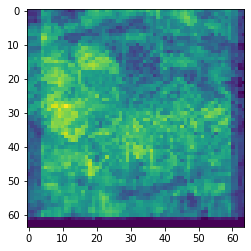

In [4]:
plt.imshow(np.array(train_set[100][0][0])+np.array(train_set[100][0][1])+np.array(train_set[100][0][2]))
print(train_set[100][1]) # Значение таргета картинки, хз что это за класс (животное какое-то)

### Вспомогательные функции, реализация модели

In [5]:
def SetRandomSeed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
class ConvNet(nn.Module): # seminars 2-3 193
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 200)
        )
        
    def forward(self, images):
        features = self.features(images)
        features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

In [ ]:
class Coach(object):
    """
    Класс объекта тренера (коучер), который обучает модель нейросетки
    """
    def __init__(self, model, optimizer, criterion,
                 device="cuda:0", scheduler=None, count_epochs=2):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        
        self.init_epoch = 1
        self.end_epoch = count_epochs
        self.epoch = self.init_epoch
        
        self.is_lr_const = False
        self.best_accuracy = 0
        self.best_model = deepcopy(self.model)

In [ ]:
class GradTrainer:
    def __init__(self, model, device, optimizer, criterion,
                 scheduler=None, cnt_epochs=2, is_lr_const=False):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        self.ClearData()
        self.epoch = 1
        self.start_epoch = 1
        self.end_epoch = cnt_epochs
        self.is_lr_const = is_lr_const
        self.best_accuracy = 0
        self.best_model = deepcopy(self.model)
    

    def _SaveIfBest(self):
        if self.test_accuracies[-1] > self.best_accuracy:
            self.best_model = deepcopy(self.model)


    def _Drop(array_1, array_2):
        array_1 = []
        array_2 = []

    
    def MakePlotOverEpochs(self, ax, train, test, name):
        if len(train) == len(test):
            GradTrainer._Drop(train, test)

        rang = range(1, self.epoch + 1)
        if len(rang) != len(test):
            rang = range(1, len(test) + 1)
        ax.plot(rang, train, label='train')
        ax.plot(rang, test, label='test')
        ax.set_title(name + ' over epochs')
        ax.set_ylabel(name)
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()
        return ax

    
    def PlotLosses(self):
        clear_output()
        _, axs = plt.subplots(1, 2, figsize=(16, 8))
        self.MakePlotOverEpochs(axs[0], self.train_losses, self.test_losses, 'Loss')
        self.MakePlotOverEpochs(axs[1], self.train_accuracies, self.test_accuracies, 'Accuracy')
        plt.show()
        

    def ClearData(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []


    def _SaveLossAndAccuracy(self, loss, predicted_labels, true_labels, is_train=False):                              
        accuracy = accuracy_score(predicted_labels.cpu(), true_labels.cpu())
        if is_train:
            self.train_losses += [loss]
            self.train_accuracies += [accuracy]
            return

        self.test_losses += [loss]
        self.test_accuracies += [accuracy]

        
    def _TrainPredict(self, data, labels):
        if self.is_lr_const:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-3)
        self.optimizer.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()

        return outputs, loss

    def _TestPredict(self, data, labels):
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)
        return outputs, loss


    def _TrainOrTest(self, loader, is_train=False, is_saving=True):
        true_labels = torch.Tensor().to(self.device)
        predicted = torch.Tensor().to(self.device)
        name = 'Training' if is_train else 'Testing'
        running_loss = 0.0
        for data, labels in tqdm(loader, desc=name + f' {self.epoch}/{self.end_epoch}'):
            data = data.to(self.device)
            labels = labels.to(self.device)
            true_labels = torch.cat((labels, true_labels))

            outputs, loss = self._TrainPredict(data, labels) if is_train else self._TestPredict(data, labels)

            predicted = torch.cat((outputs, predicted))

            if loss.item() != np.inf:
                running_loss += loss.item() * data.shape[0]

        loss = running_loss / len(loader.dataset)
        predict_labels = torch.argmax(predicted, dim=1)
        
        if is_saving:
            self._SaveLossAndAccuracy(loss, predict_labels, true_labels, is_train)

        return loss, predict_labels, true_labels
    

    def Train(self, data_loader):
        return self._TrainOrTest(data_loader, is_train=True)
    

    def Test(self, data_loader, is_saving=False):
        return self._TrainOrTest(data_loader, is_train=False, is_saving=is_saving)
    

    def TestAndTrainOnce(self, train_loader, test_loader):
        self.Train(train_loader)
        self.Test(test_loader, is_saving=True)
        self._SaveIfBest()
        if self.scheduler is not None:
            self.scheduler.step()
    

    def train(self, train_loader, test_loader):
        if self.start_epoch > self.end_epoch:
            return
        for self.epoch in range(self.start_epoch, self.end_epoch + 1):
            self.TestAndTrainOnce(train_loader, test_loader)
            self.PlotLosses()
            if self.is_lr_const and len(self.train_losses) > 1:
                self.is_lr_const = (self.train_losses[-2] > self.train_losses[-1] or
                                    self.train_losses[-1] < 1.5)

In [7]:
def train(model, train_dataloader, eval_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, schedulder=None):
    for epoch in range(n_epochs):
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        loss = evaluate(model, eval_dataloader, criterion, device)
        if schedulder is not None:
            scheduler.step(loss)
    
def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    progress_bar = tqdm_notebook(train_dataloader)
    model = model.to(device).train()
    idx = 0
    for (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % 10 == 0:
            progress_bar.set_description("Loss = {:.4f}".format(loss.item()))
        idx += 1
        
def evaluate(model, eval_dataloader, criterion, device="cuda:0"):
    cumulative_loss = 0
    acc = 0
    model = model.to(device).eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(eval_dataloader): 
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            cumulative_loss += loss.item()
            acc += (preds.argmax(1) == labels).float().mean()
    print("Loss = {:.4f}".format(cumulative_loss / idx), "accuracy = {:.4f}".format(acc / idx))
    return cumulative_loss        self.start_epoch = self.end_epoch + 1

SyntaxError: invalid syntax (<ipython-input-7-98b0ac1d95c5>, line 179)

### Обучение модели, запуски экспериментов

In [ ]:
model = # THE MODEL THAT YOU CHOOSE
optimizer = # YOUR OPTIMIZER
criterion = # LOSS THAT YOU OPTIMIZE (SHOLD BE CROSS ENTROPY OR SMTH ELSE)
scheduler = # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = # NUMBER OF EPOCHS
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

seed = SetRandomSeed(111)
device = SetupDevice()
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()
scheduler = None # torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
trainer = GradTrainer(model, device, optimizer, criterion, scheduler, cnt_epochs=10)

In [ ]:
SetRandomSeed(111)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")
accuracy = 0.42
print(f'Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов,'\
      f' если вы делали часть 1, и {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов,'\
      f' если вы делали часть 2.')

In [ ]:
all_losses, predicted_labels, true_labels = trainer.Test(val_loader)
assert len(predicted_labels) == len(val_set)
accuracy = accuracy_score(predicted_labels.cpu(), true_labels.cpu())
print("tests passed")